In [1]:
%load_ext autoreload
%autoreload 2

# `Logit` on Orders - A warm-up challenge (~1h)

## Select features

🎯 Let's figure out the impact of `wait_time` and `delay_vs_expected` on very `good/bad reviews`

👉 Using our `orders` training_set, we will run two `multivariate logistic regressions`:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

 

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

👉 Import your dataset:

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)

👉 Select in a list which features you want to use:

⚠️ Make sure you are not creating data leakage (i.e. selecting features that are derived from the target)

💡 To figure out the impact of `wait_time` and `delay_vs_expected` we need to control for the impact of other features, include in your list all features that may be relevant

In [4]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'review_score', 'dim_is_five_star', 'dim_is_one_star',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [5]:
selected_features = ["wait_time", 
            "delay_vs_expected",
            "number_of_sellers", 
            "distance_seller_customer", 
            "price", 
            "freight_value"]

🕵🏻 Check the `multi-colinearity` of your features, using the `VIF index`.

* It shouldn't be too high (< 10 preferably) to ensure that we can trust the partial regression coefficents and their associated `p-values` 
* Do not forget to standardize your data ! 
    * A `VIF Analysis` is made by regressing a feature vs. the other features...
    * So you want to `remove the effect of scale` so that your features have an equal importance before running any linear regression!
    
    
📚 <a href="https://www.statisticshowto.com/variance-inflation-factor/">Statistics How To - Variance Inflation Factor</a>

📚  <a href="https://online.stat.psu.edu/stat462/node/180/">PennState - Detecting Multicollinearity Using Variance Inflation Factors</a>

⚖️ Standardizing:

In [6]:
orders_standardized = orders.copy()

for f in selected_features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
    
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,review_score,dim_is_five_star,dim_is_one_star,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,4,0,0,1,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,4,0,0,1,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,5,1,0,1,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,5,1,0,1,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,5,1,0,1,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,5,1,0,1,-0.112544,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,4,0,0,1,-0.112544,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,5,1,0,1,-0.112544,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,2,0,0,2,-0.112544,1.075186,2.715522,-0.387558


👉 Run your VIF Analysis to analyze the potential multicolinearities:

In [7]:
X_standardized = orders_standardized[selected_features]
X_standardized.head()

,wait_time,delay_vs_expected,number_of_sellers,distance_seller_customer,price,freight_value
0,-0.431192,-0.161781,-0.112544,-0.979475,-0.513802,-0.652038
1,0.134174,-0.161781,-0.112544,0.429743,-0.086640,0.000467
2,-0.329907,-0.161781,-0.112544,-0.145495,0.111748,-0.164053
3,0.073540,-0.161781,-0.112544,2.054621,-0.441525,0.206815
4,-1.019535,-0.161781,-0.112544,-0.959115,-0.562388,-0.652038


In [8]:
X_standardized.shape

(95872, 6)

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df = pd.DataFrame()
df["features"] = X_standardized.columns
df["vif_index"] = [vif(X_standardized.values, i) for i in range(X_standardized.shape[1])]
round(df,2)

,features,vif_index
0,wait_time,2.62
1,delay_vs_expected,2.21
2,number_of_sellers,1.02
3,distance_seller_customer,1.41
4,price,1.21
5,freight_value,1.36


## Logistic Regressions

👉 Fit two `Logistic Regression` models:
- `logit_one` to predict `dim_is_one_star` 
- `logit_five` to predict `dim_is_five_star`.

`Logit 1️⃣`

In [10]:
logit_one = smf.logit(formula='dim_is_one_star ~'+ ' + '.join(selected_features), data=orders_standardized).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.276470
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        dim_is_one_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Jul 2022   Pseudo R-squ.:                  0.1357
Time:                        17:39:59   Log-Likelihood:                -26506.
converged:                       True   LL-Null:                       -30669.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.4472      0.013   -191.764      0.000      -2.472      -2.422
wait_time                    0.6907      0.017     41.192      0.000       0.658       0.724
delay_vs_expected            0.2626      0.018     14.238      0.000       0.226       0.299
number_of_sellers            0.2295      0.008     30.500      0.000       0.215       0.244
distance_seller_customer    -0.2193      0.014    -16.023      0.000      -0.246      -0.192
price                        0.0407      0.011      3.776      0.000       0.020       0.062
freight_value                0.1090      0.011      9.790      0.000       0.087       0.131
============================================================================================
"""

In [11]:
logit_one.params[1]

0.690706224653131

In [27]:
import numpy as np

log_odd = logit_one.params[1]

odds = np.exp(log_odd)

print(odds)

print(f'For each new day of wait time the odds of getting a 1 star review increases by {odds:.2f}\
 holding other features constant')

1.9951240416071128
For each new day of wait time the odds of getting a 1 star review increases by 2.00 holding other features constant


In [28]:
probability = odds/(1+odds)

print(probability)

print(f'for each new day of wait time the probability of getting a 1 star review increases by {probability*100:.2f}%\
 holding other features constant')

0.6661240115239355
for each new day of wait time the probability of getting a 1 star review increases by 66.61% holding other features constant


`Logit 5️⃣`

In [14]:
logit_five = smf.logit(formula='dim_is_five_star ~'+ ' + '.join(selected_features), data=orders_standardized).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.638281
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Jul 2022   Pseudo R-squ.:                 0.05591
Time:                        17:39:59   Log-Likelihood:                -61193.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3383      0.007     47.337      0.000       0.324       0.352
wait_time                   -0.5140      0.012    -44.101      0.000      -0.537      -0.491
delay_vs_expected           -0.4366      0.024    -18.569      0.000      -0.483      -0.390
number_of_sellers           -0.1716      0.008    -22.517      0.000      -0.187      -0.157
distance_seller_customer     0.1075      0.008     13.039      0.000       0.091       0.124
price                        0.0268      0.008      3.476      0.001       0.012       0.042
freight_value               -0.0624      0.009     -7.305      0.000      -0.079      -0.046
============================================================================================
"""

💡 It's time to analyse the results of these two logistic regressions:

- Interpret the partial coefficients in your own words.
- Check their statistical significances with `p-values`
- Do you notice any differences between `logit_one` and `logit_five` in terms of coefficient importances?

In [15]:
# Among the following sentences, store the ones that are true in the list below

a = "delay_vs_expected influences five_star ratings even more than one_star ratings"
b = "wait_time influences five_star ratings even more more than one_star"

your_answer = [a]

🧪 __Test your code__

In [16]:
from nbresult import ChallengeResult

result = ChallengeResult('logit',
    answers = your_answer
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/matheus/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/matheus/code/matheussposito/data-challenges-869/04-Decision-Science/04-Logistic-Regression/01-Logit
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_logit.py::TestLogit::test_question PASSED                     [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/logit.pickle

git commit -m 'Completed logit step'

git push origin master


<details>
    <summary>- <i>Explanations and advanced concepts </i> -</summary>


> _All other thing being equal, the `delay factor` tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries_
    
❗️ However, to be totally rigorous, we have to be **more careful when comparing coefficients from two different models**, because **they might not be based on similar populations**!
    We have 2 sub-populations here: (people who gave 1-stars; and people who gave 5-stars) and they may exhibit intrinsically different behavior patterns. It may well be that "happy-people" (who tends to give 5-stars easily) are less sensitive as "grumpy-people" (who shoot 1-stars like Lucky-Luke), when it comes to "delay", or "price"...

</details>


## Logistic vs. Linear ?

👉 Compare:
- the regression coefficients obtained from the `Logistic Regression `
- with the regression coefficients obtained through a `Linear Regression` 
- on `review_score`, using the same features. 

⚠️ Check that both sets of coefficients  tell  "the same story".

> YOUR ANSWER HERE

### Linear Regression

In [17]:
linear_model = smf.ols('review_score ~'+ ' + '.join(selected_features), data=orders_standardized).fit()

In [18]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2548.
Date:                Tue, 19 Jul 2022   Prob (F-statistic):               0.00
Time:                        17:40:00   Log-Likelihood:            -1.5299e+05
No. Observations:               95872   AIC:                         3.060e+05
Df Residuals:                   95865   BIC:                         3.061e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.1555      0.004   1078.062      0.000       4.148       4.163
wait_time                   -0.4339      0.006    -69.508      0.000      -0.446      -0.422
delay_vs_expected           -0.0542      0.006     -9.459      0.000      -0.065      -0.043
number_of_sellers           -0.1605      0.004    -41.135      0.000      -0.168      -0.153
distance_seller_customer     0.1156      0.005     25.235      0.000       0.107       0.125
price                        0.0020      0.004      0.463      0.643      -0.006       0.010
freight_value               -0.0575      0.004    -12.780      0.000      -0.066      -0.049
==============================================================================
Omnibus:                    19262.676   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38986.572
Skew:                          -1.204   Prob(JB):                         0.00
Kurtosis:                       4.989   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Logistic Regression

In [19]:
logit_five.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       dim_is_five_star   No. Observations:                95872
Model:                          Logit   Df Residuals:                    95865
Method:                           MLE   Df Model:                            6
Date:                Tue, 19 Jul 2022   Pseudo R-squ.:                 0.05591
Time:                        17:40:00   Log-Likelihood:                -61193.
converged:                       True   LL-Null:                       -64817.
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.3383      0.007     47.337      0.000       0.324       0.352
wait_time                   -0.5140      0.012    -44.101      0.000      -0.537      -0.491
delay_vs_expected           -0.4366      0.024    -18.569      0.000      -0.483      -0.390
number_of_sellers           -0.1716      0.008    -22.517      0.000      -0.187      -0.157
distance_seller_customer     0.1075      0.008     13.039      0.000       0.091       0.124
price                        0.0268      0.008      3.476      0.001       0.012       0.042
freight_value               -0.0624      0.009     -7.305      0.000      -0.079      -0.046
============================================================================================
"""

<AxesSubplot:title={'center':'Logit'}>

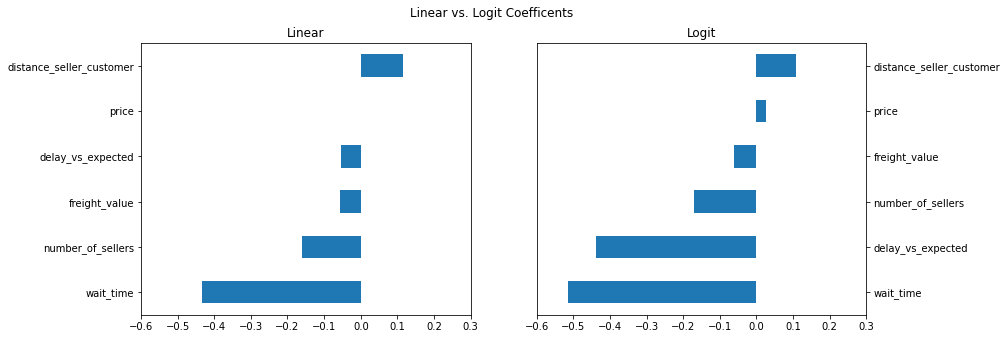

In [20]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficents')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-0.6, 0.3)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)


ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-0.6, 0.3)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

🏁 Congratulations! 

💾 Don't forget to commit and push your `logit.ipynb` notebook !